<h1 align="center"> Диагностика рака молочной железы в Висконсине </h1>

Источник данных: 
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data 


В этом ноутбуке будут опробованы различные прогностические модели, чтобы увидеть, насколько они точны при определении является ли опухоль злокачественной или доброкачественной.

<h2> План: </h2>
<ul>
<li> Визуализировать данные для упрощения понимания. </li>
<li> Понять, насколько несбалансированн имеющийся набор данных. </li>
<li> Создать соотношение 50/50 для классов (диагнозов) злокачественных и доброкачественных опухолей. </li>
<li> Опробовать несколько классификаторов и определить, какой из них является наиболее точным. </li>
<li> Создать нейронную сеть и сравнить точность с лучшим классификатором. </li>
<li> Понять распространенные ошибки, допускаемые при использовании разбалансированных наборов данных. </li>
</ul>


<h2> Содержание: </h2>

I. <b>[Описание и визуализация](#gather)</b><br>
1. [Описание](#description)
2. [Визуализация](#visalization)
3. [Распределение по классам](#class_distribution)
4. [Корреляция](#correlation)

II. <b>[Предобработка](#pretreatment)</b>
1. [Масштабирование](#distributing)
2. [Создане уменьшенного набора данных (Random Under-Sampling)](#under_sampling)
3. [Разделение исходного набора](#splitting)
4. [Определение аномалий](#anomaly)<br>

III. <b>[Классификация](#classification)</b><br>
3. [Снижение размерности и кластеризация (t-SNE)](#clustering)
4. [Классификаторы](#classifiers)
5. [Более подробное рассмотрение логистической регрессии](#logistic)
6. [Сэмплирование данных с SMOTE](#smote)
7. [Тестирование классификаторов](#testing)

IV. <b>[Нейронные сети, обучаемые на разных наборах данных Under-Sample и Over-Sample](#neural_networks) </b><br>


# Описание и визуализация данных
<a id="gather"></a>

In [1]:
# Импорт библиотек

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Другие
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## Описание
<a id="description"></a>

In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Заменяем символьные значения на численные в столбце 'diagnosis': 1 - злокачественные, 0 - доброкачественные
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
# Удаляем столбцы, которые не понадобятся
del df['id']
del df['Unnamed: 32']

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Общая статистика df
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [5]:
# количество значений Null
df.isnull().sum().max()

0

### Названия столбцов

<b> ID больного и диагноз: </b>	
1	-	id - идентификационный номер пациента	
2	-	diagnosis -	диагноз тканей молочной железы (1 - злокачественная, 0 - доброкачественная)	

<b> Средниие значения признаков: </b>	
3	-	radius mean	- среднее расстояние от центра до точек по периметру	
4	-	texture mean - среднее значение текстуры по серой шкалы	
5	-	perimeter mean - средний значение периметра	
6	-	area mean - средняя площадь поверхности	
7	-	smoothness mean	- среднее локального изменения длины радиуса	
8	-	compactness mean - (среднее периметра ^ 2 / площадь) - 1,0	
9	-	concavity mean - средний вес вогнутых частей контура	
10	-	concave points mean - среднее число вогнутых частей контура	
11	-	symmetry mean -	среднее значение симметрии	
12	-	fractal dimension mean - среднее значение для фрактальной размерности пограничной линии	

<b> СКО (среднеквадратическое отклоненние) признаков: </b>	
13	-	radius se - СКО расстояния от центра до точек по периметру	
14	-	texture se - СКО значений текстуры по серой шкале	
15	-	perimeter se - СКО длины перимета	
16	-	area se - СКО лощади поверхности	
17	-	smoothness se - СКО локального изменения длины радиуса	
18	-	compactness se	- СКО по параметру = (периметр ^ 2 / площадь) - 1,0	
19	-	concavity se - СКО веса вогнутых частей контура	
20	-	concave points se - СКО количества вогнутых частей контура	
21	-	symmetry se	- СКО симметрии	
22	-	fractal dimension se - СКО фрактальной размерности пограничной линии	

<b> Наибольшие значения признаков: </b>	
23	-	radius worst - наибольшее значение среднего расстояния от центра до точек по периметру	
24	-	texture worst - наибольшее значение стандартного отклонения значений серой шкалы	
25	-	perimeter worst - наибольшее значение длины перимета	
26	-	area worst - наибольшее значение площади поверхности	
27	-	smoothness worst - наибольшее значение локального изменения длины радиуса	
28	-	compactness worst - наибольшее значение параметра = (периметр ^ 2 / площадь) - 1,0	
29	-	concavity worst - наибольшее значение веса вогнутых частей контура	
30	-	concave points worst - наибольшее значение количества вогнутых частей контура	
31	-	symmetry worst	- наибольшее значение симметрии	
32	-	fractal dimension worst - наибольшее значение фрактальной размерности пограничной линии	

In [6]:
# Создадим массивы с названиями столбцов в df и названиями для отображения на графиках 

# Массив с названиями колонок
column_names = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
                'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
                'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
                'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
                'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
# Массив с краткими названиями на русском. Потом пригодиться
rus_titles = ['Диагноз','Средний радиус','Среднее значение текстуры','Средний периметр','Средняя площадь',
             'Среднее значение гладкости','Среднее значение параметра \n P**2 / S - 1','Cредний вес вогнутых частей',
             'Cреднее число вогнутых частей','Cреднее значение симметрии','Средняя фрактальная размерность \n пограничной линии',
             'СКО радиуса','СКО значения текстуры','СКО периметра','СКО площади','СКО значения гладкости',
             'СКО значения параметра \n P^2/S - 1','СКО веса вогнутых частей','СКО числа вогнутых частей',
             'СКО значения симметрии','СКО фрактальной размерности \n пограничной линии','Наибольший радиус',
             'Наибольшее значение текстуры','Наибольший периметр','Наибольшая площадь','Наибольшее значение гладкости',
             'Наибольшее значение параметра \n P^2/S - 1','Наибольший вес вогнутых частей','Наибольшее число вогнутых частей',
             'Наибольшее значение симметрии','Наибольшая фрактальная \n размерность пограничной линии']

print(len(column_names), len(rus_titles))

31 31


## Визуализация
<a id="visalization"></a>

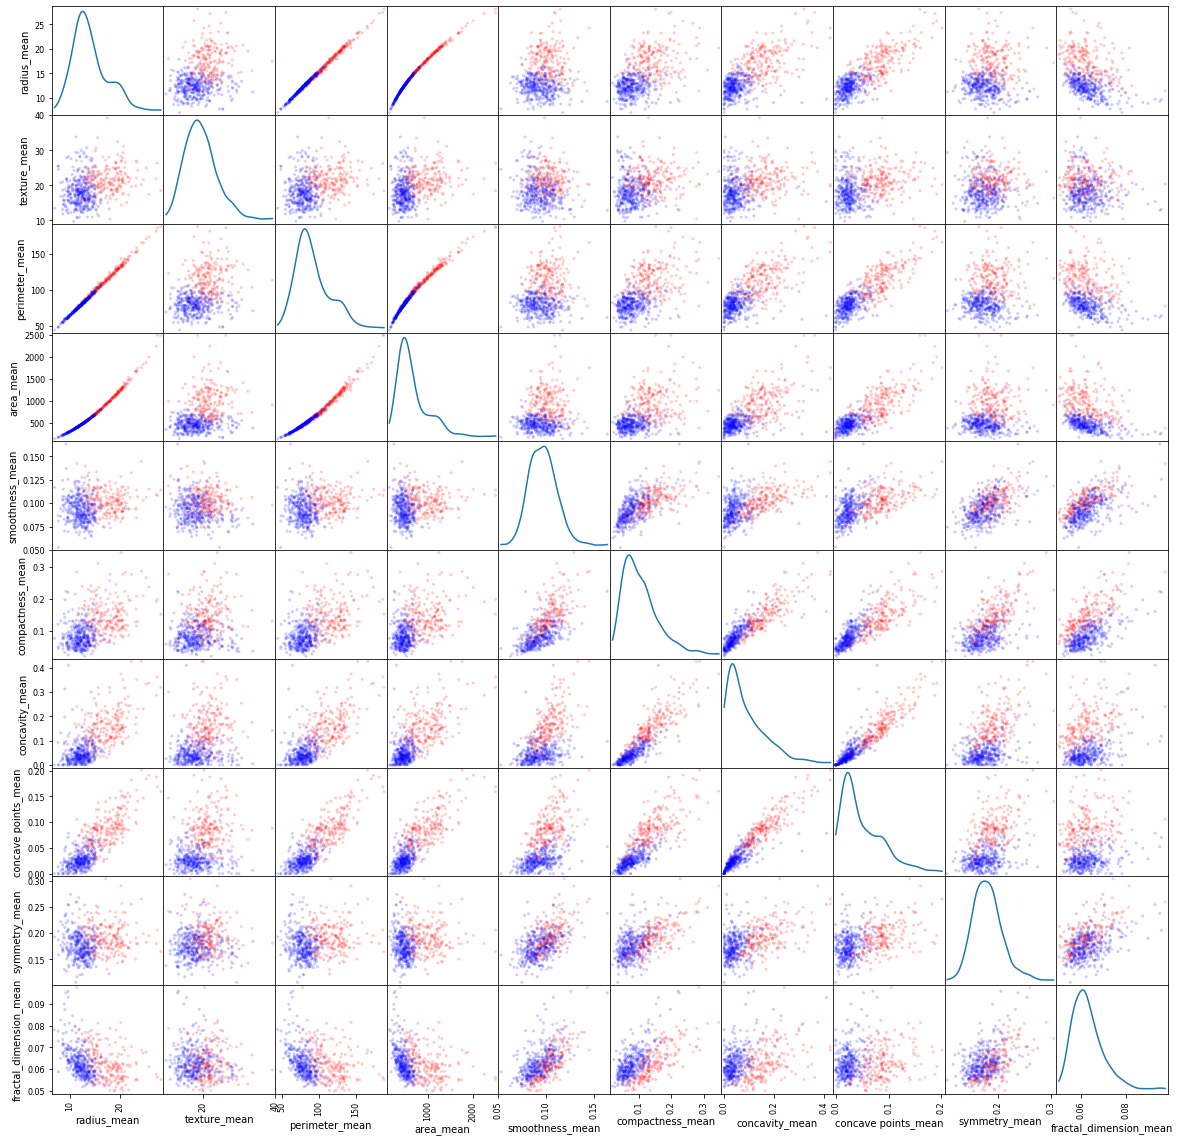

In [7]:
from pandas.plotting import scatter_matrix
colors = {0: 'b', 1: 'r'}

scatter_matrix(df.iloc[:,1:11], # матрица для колонок под индексами 1:11
               # размер картинки
               figsize=(20, 20),
               # плотность вместо гистограммы на диагонали
               diagonal='kde',
               # цвета классов
               c=df['diagnosis'].replace(colors),
               # степень прозрачности точек
               alpha=0.2,
              );

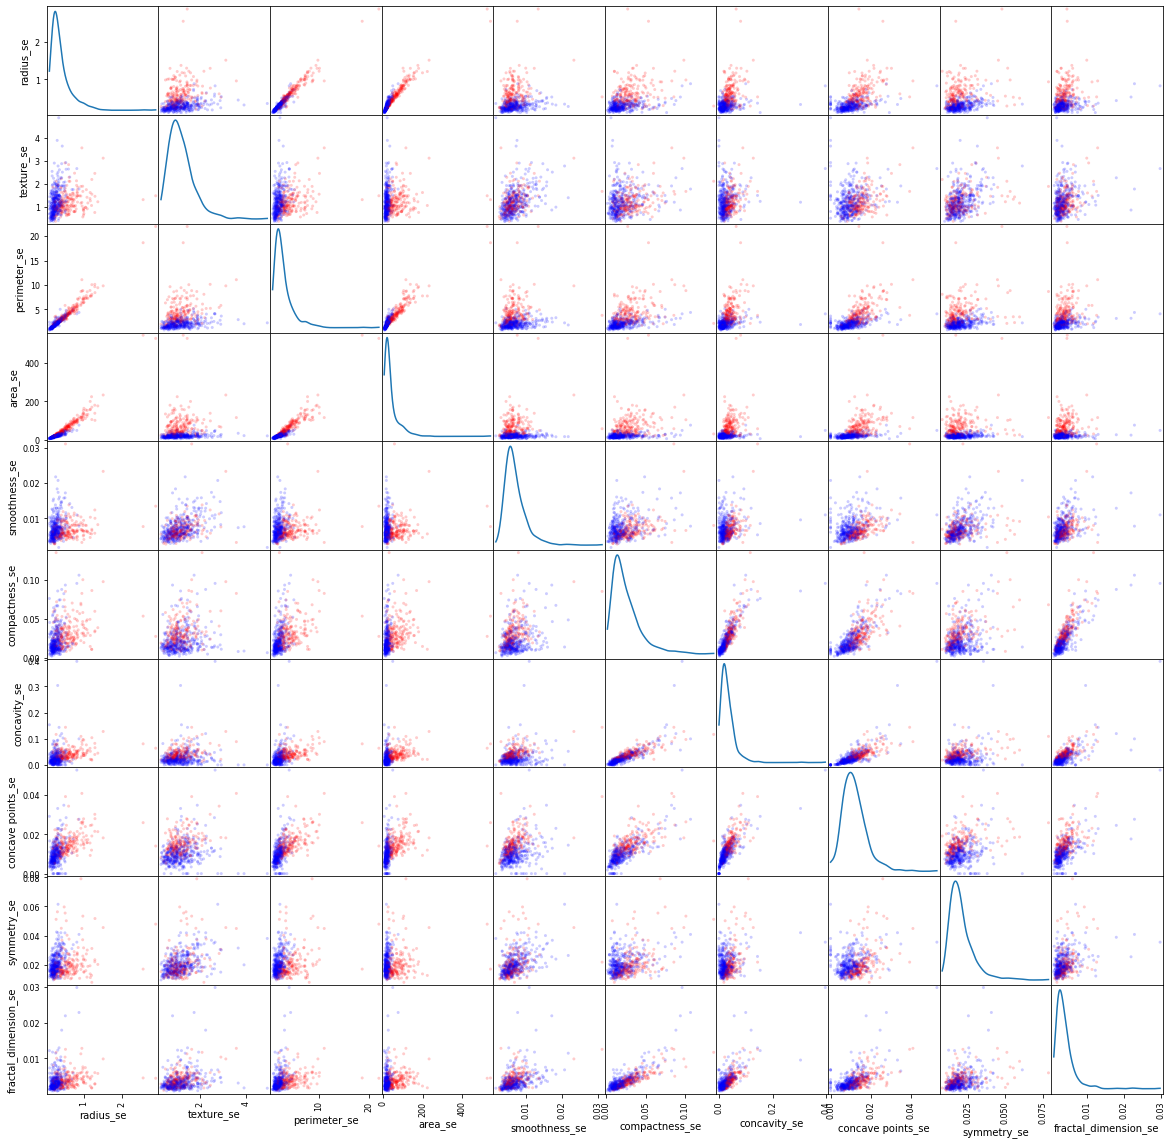

In [8]:
scatter_matrix(df.iloc[:,11:21], 
               figsize=(20, 20),
               diagonal='kde',
               c=df['diagnosis'].replace(colors),
               alpha=0.2,
              );

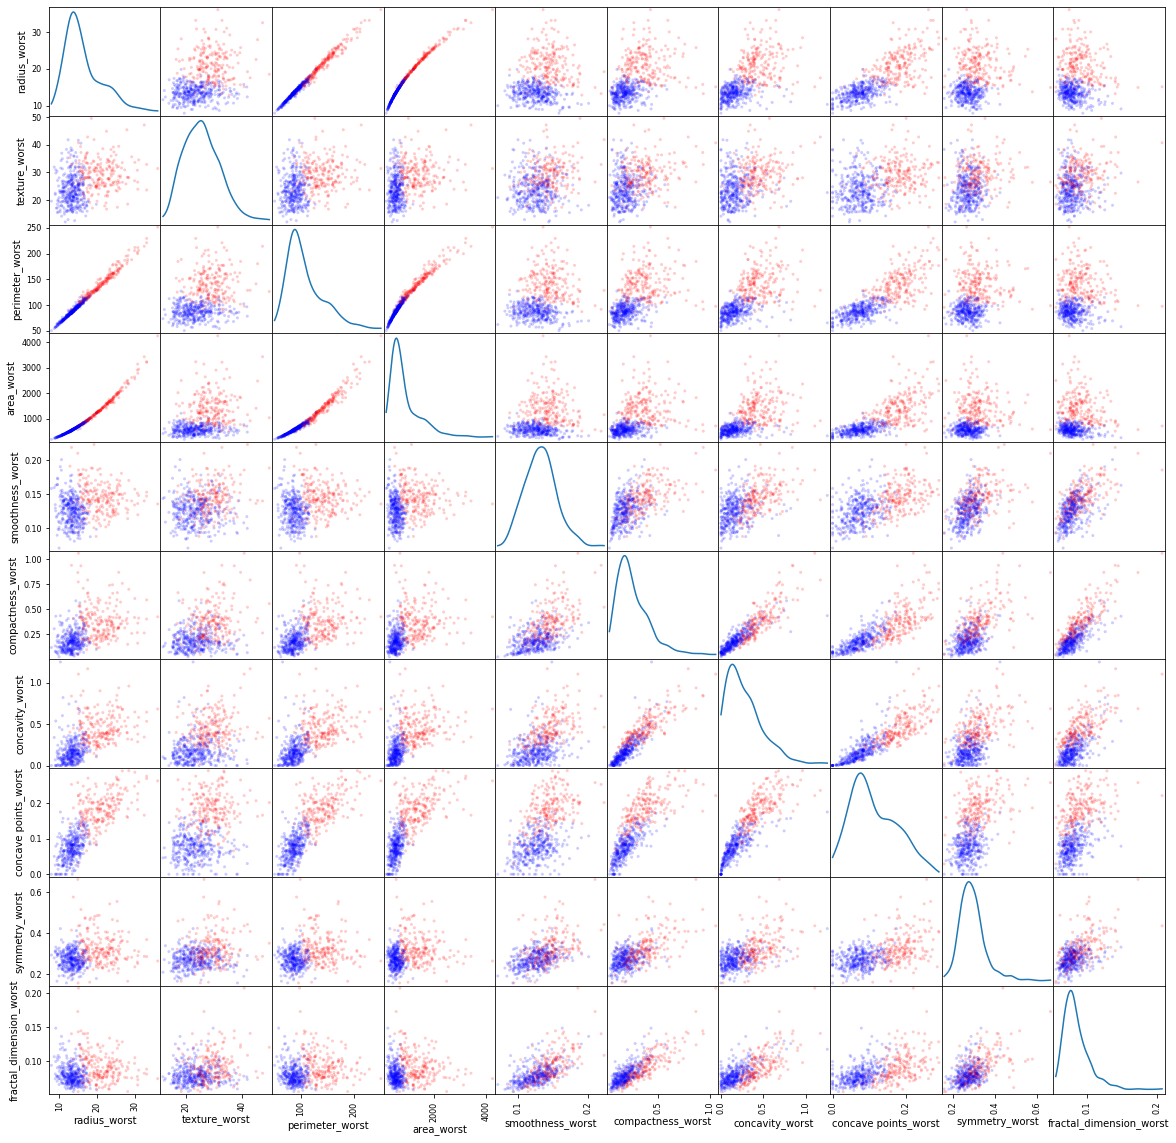

In [9]:
scatter_matrix(df.iloc[:,21:31],
               figsize=(20, 20),
               diagonal='kde',
               c=df['diagnosis'].replace(colors),
               alpha=0.2,
              );

На "scatter matrix" видно, что точки зависимости периметра от радиуса с большой точностью ложатся на одну прямую (P = 2 Pi r), а точки зависимости площади от радиуса на линию параболы (S = Pi r^2). Такое расположение точек итих зависимостей возможно в двух случаях: 1 - значения площади и периметра были получены путем вычисления, 2 - геометрические формы опухолей очень правильные. Второе предположение опровергается наличием значительных разбросов точек по другим параметрам, характеризующим геометрию формы. Незначительный разброс точек для зависомостей периметра и площади от радиуса скорее всего обусловлен округлением чесел (можно это доказать, но этого делать в данном случае не обязательно). Для более более ясной понимания данных посмотрим на митрицу корреляции:

## Распределение по классам
<a id="class_distribution"></a>

In [10]:
# Классы разбалансированны
print('Классификация опухолей молочной железы:')
print('доброкачественные состовляют ', 
      round(df['diagnosis'].value_counts()[0]/len(df) * 100,2), '% диагнозов;')
print('злокачественные состовляют ', round(df['diagnosis'].value_counts()[1]/len(df) * 100,2), '% диагнозов.')

Классификация опухолей молочной железы:
доброкачественные состовляют  62.74 % диагнозов;
злокачественные состовляют  37.26 % диагнозов.


Text(0.5, 1.0, 'Распределение диагнозов \n (0: Доброкачественная || 1: Злокачественная)')

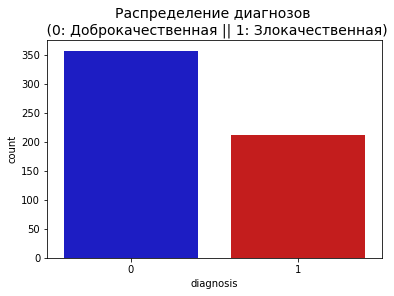

In [11]:
# Посмотрим как выглядит соотношение классов
colors = ["#0101DF", "#DF0101"]

sns.countplot('diagnosis', data=df, palette=colors)
plt.title('Распределение диагнозов \n (0: Доброкачественная || 1: Злокачественная)', fontsize=14)

## Корреляция
<a id="correlation"></a>

In [12]:
# Т.к. количество диагнозов доброкачественных и злокачественных опухолей отличается, 
# нам надо выровнить их для того, чтобы получить корректные коэффициенты корреляции

# Перемешаем данные перед созданием подвыборок

df_for_mcor = df.loc[:]
df_for_mcor = df_for_mcor.sample(frac=1).reset_index(drop=True)

# M = malignant (злокачественная), B = benign (доброкачественная)
# количество строк для класса злокачественных опухолей - 212.
malignant_df_for_mcor = df_for_mcor.loc[df['diagnosis'] == 1]
benign_df_for_mcor = df_for_mcor.loc[df['diagnosis'] == 0][:212]

# объединение malignant_df и benign_df
normal_distributed_df_for_mcor = pd.concat([malignant_df_for_mcor, benign_df_for_mcor])

# Перемешиваем строки в наборе данных
new_df_for_mcor = normal_distributed_df_for_mcor.sample(frac=1).reset_index(drop=True)

In [13]:
new_df_for_mcor

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,19.000,18.91,123.40,1138.0,0.08217,0.08028,0.09271,0.056270,0.1946,...,22.32,25.73,148.20,1538.0,0.1021,0.22640,0.32070,0.12180,0.2841,0.06541
1,0,11.800,17.26,75.26,431.9,0.09087,0.06232,0.02853,0.016380,0.1847,...,13.45,24.49,86.00,562.0,0.1244,0.17260,0.14490,0.05356,0.2779,0.08121
2,0,13.680,16.33,87.76,575.5,0.09277,0.07255,0.01752,0.018800,0.1631,...,15.85,20.20,101.60,773.4,0.1264,0.15640,0.12060,0.08704,0.2806,0.07782
3,1,19.070,24.81,128.30,1104.0,0.09081,0.21900,0.21070,0.099610,0.2310,...,24.09,33.17,177.40,1651.0,0.1247,0.74440,0.72420,0.24930,0.4670,0.10380
4,1,17.060,21.00,111.80,918.6,0.11190,0.10560,0.15080,0.099340,0.1727,...,20.99,33.15,143.20,1362.0,0.1449,0.20530,0.39200,0.18270,0.2623,0.07599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0,12.900,15.92,83.74,512.2,0.08677,0.09509,0.04894,0.030880,0.1778,...,14.48,21.82,97.17,643.8,0.1312,0.25480,0.20900,0.10120,0.3549,0.08118
420,0,14.020,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.026520,0.1589,...,14.91,19.31,96.53,688.9,0.1034,0.10170,0.06260,0.08216,0.2136,0.06710
421,0,9.731,15.34,63.78,300.2,0.10720,0.15990,0.41080,0.078570,0.2548,...,11.02,19.49,71.04,380.5,0.1292,0.27720,0.82160,0.15710,0.3108,0.12590
422,0,9.683,19.34,61.05,285.7,0.08491,0.05030,0.02337,0.009615,0.1580,...,10.93,25.59,69.10,364.2,0.1199,0.09546,0.09350,0.03846,0.2552,0.07920


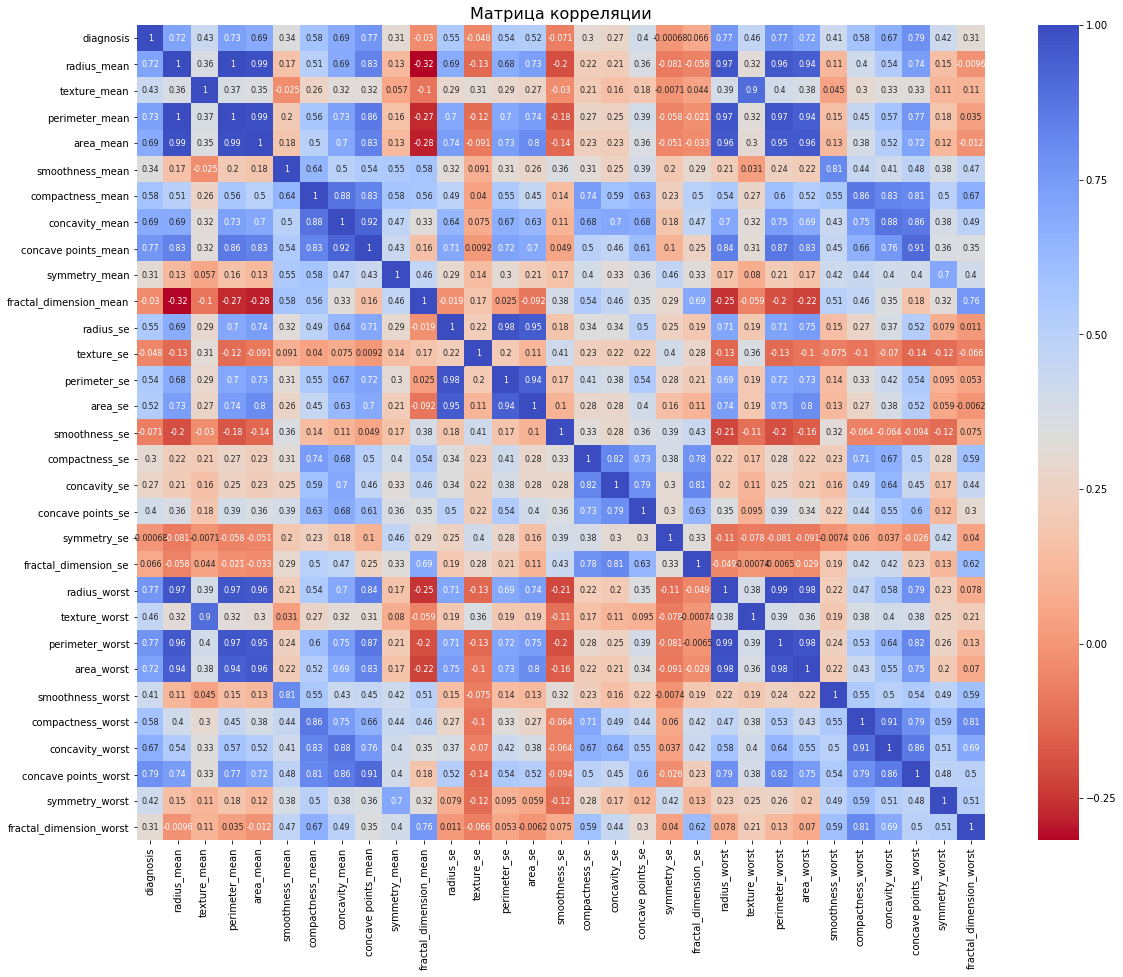

In [14]:
# матрица корреляции для new_df_for_mcor (с равномерным распределением классов)

f = plt.figure(figsize=(19, 15))
corr = new_df_for_mcor.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
plt.title('Матрица корреляции', fontsize=16);

### Как видно из матрицы корреляции сильно коррелируют:
- с радиусом - переметр и полощадь (коэффициенты 1,0 и 0,99 соответстенно), 
- с параметром P^2 / S - 1 - вес и количество вогнутых частей (коэффициенты 0,88 и 0,84 соответственно),
- с количеством вогнутых частей - вес вогнутых частей (коэффициент 0,92).
Для наглядности построим на эти зависимости ближе.

Зависимости средних значений:


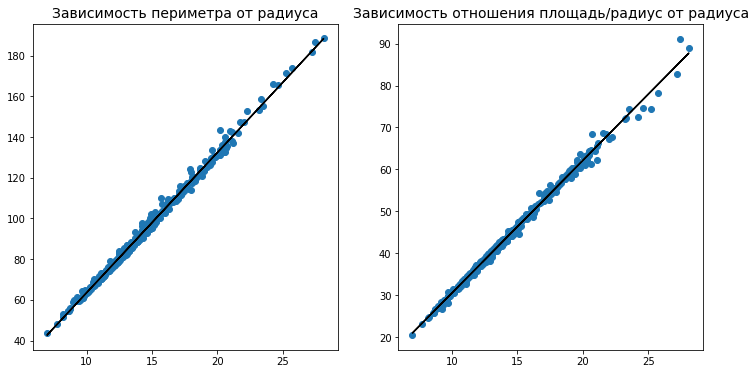

In [15]:
def sub_scatter(x, y):
    plt.scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"k-")
    

print("Зависимости средних значений:")
plt.subplots(figsize=(12,6))
plt.subplot(121)
sub_scatter(new_df_for_mcor['radius_mean'], new_df_for_mcor['perimeter_mean'])
plt.title('Зависимость периметра от радиуса', fontsize=14)

plt.subplot(122)
sub_scatter(new_df_for_mcor['radius_mean'], new_df_for_mcor['area_mean'] / new_df_for_mcor['radius_mean'],)
plt.title('Зависимость отношения площадь/радиус от радиуса', fontsize=14)


plt.show()

Зависимости средних значений:


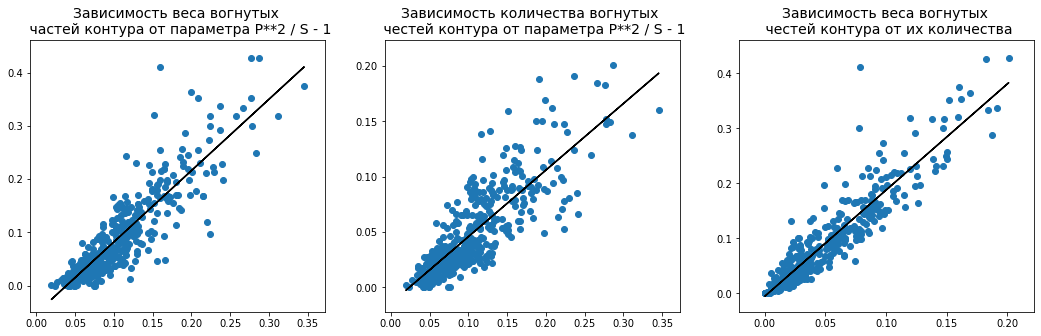

In [16]:
print("Зависимости средних значений:")

plt.subplots(figsize=(18,5))
plt.subplot(131)
sub_scatter(new_df_for_mcor['compactness_mean'], new_df_for_mcor['concavity_mean'])
plt.title('Зависимость веса вогнутых \n частей контура от параметра P**2 / S - 1', fontsize=14)

plt.subplot(132)
sub_scatter(new_df_for_mcor['compactness_mean'], new_df_for_mcor['concave points_mean'])
plt.title('Зависимость количества вогнутых \n честей контура от параметра P**2 / S - 1', fontsize=14)

plt.subplot(133)
sub_scatter(new_df_for_mcor['concave points_mean'], new_df_for_mcor['concavity_mean'])
plt.title('Зависимость веса вогнутых \n честей контура от их количества', fontsize=14)

plt.show()

In [17]:
# Удалим сильно коррелирующие признаки из df, т.к. они не несут полезной информации
# а так же удалим соответствующие значения из column_names иrus_titles
columns = ['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'concavity_se', 
             'concave points_se', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst']
new_df_for_mcor.drop(columns, inplace=True, axis=1)

del_col = [3, 4, 7, 8, 13, 14, 17, 18, 23, 24, 27, 28]
column_names = np.delete(column_names, del_col).tolist()
rus_titles = np.delete(rus_titles, del_col).tolist()

In [18]:
# все нормально?
i = 0
while i < len(column_names):
    print(i, column_names[i], " - ", rus_titles[i])
    i += 1
    
df.head()

0 diagnosis  -  Диагноз
1 radius_mean  -  Средний радиус
2 texture_mean  -  Среднее значение текстуры
3 smoothness_mean  -  Среднее значение гладкости
4 compactness_mean  -  Среднее значение параметра 
 P**2 / S - 1
5 symmetry_mean  -  Cреднее значение симметрии
6 fractal_dimension_mean  -  Средняя фрактальная размерность 
 пограничной линии
7 radius_se  -  СКО радиуса
8 texture_se  -  СКО значения текстуры
9 smoothness_se  -  СКО значения гладкости
10 compactness_se  -  СКО значения параметра 
 P^2/S - 1
11 symmetry_se  -  СКО значения симметрии
12 fractal_dimension_se  -  СКО фрактальной размерности 
 пограничной линии
13 radius_worst  -  Наибольший радиус
14 texture_worst  -  Наибольшее значение текстуры
15 smoothness_worst  -  Наибольшее значение гладкости
16 compactness_worst  -  Наибольшее значение параметра 
 P^2/S - 1
17 symmetry_worst  -  Наибольшее значение симметрии
18 fractal_dimension_worst  -  Наибольшая фрактальная 
 размерность пограничной линии


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


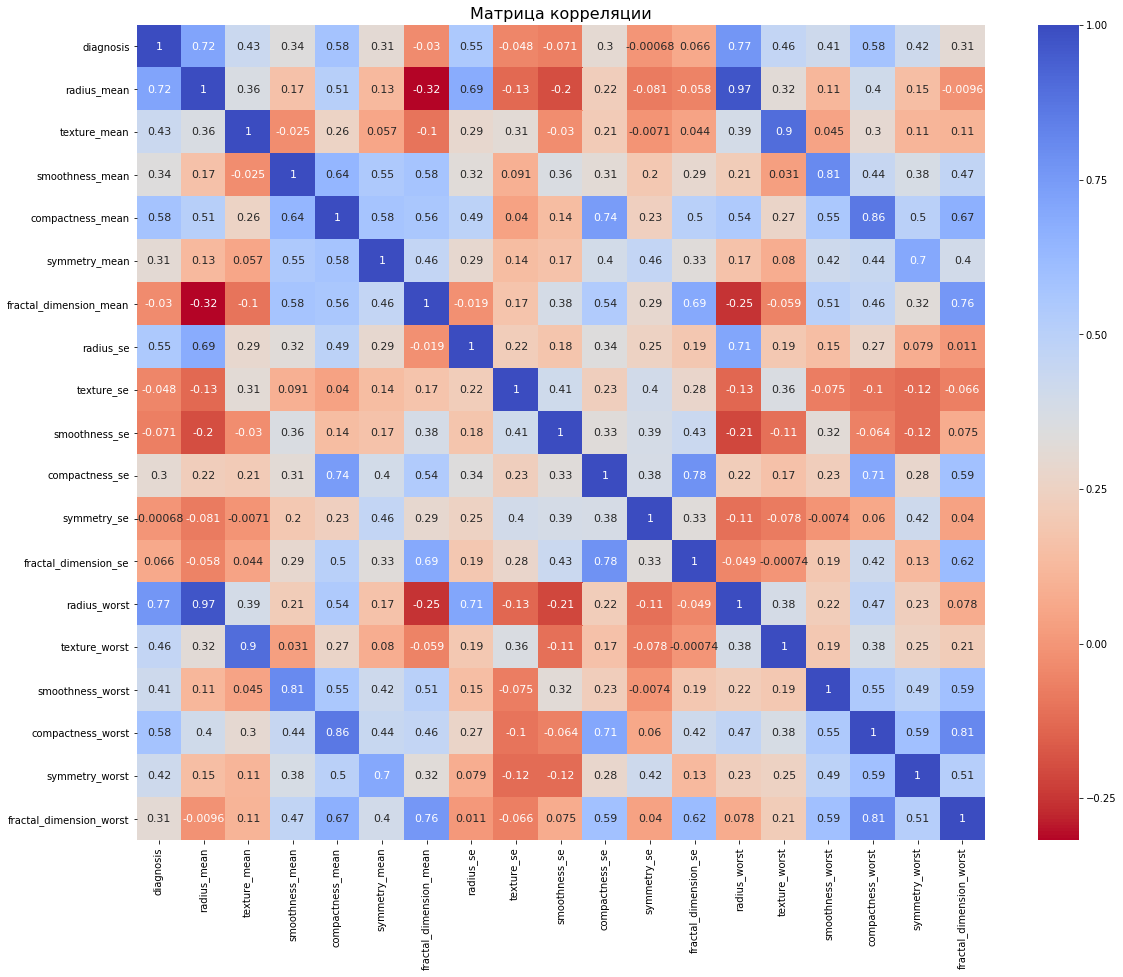

In [19]:
# Построим матрицу корреляции без сильно коррелирующих признаков
f = plt.figure(figsize=(19, 15))
corr = new_df_for_mcor.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':11})
plt.title('Матрица корреляции', fontsize=16);

In [20]:
# Теперь удалим те же столбцы из исходного набора данных, и дальше будем работать с ним
df.drop(columns, inplace=True, axis=1)

df.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.03003,0.006193,25.38,17.33,0.1622,0.6656,0.4601,0.11890
1,1,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2750,0.08902
2,1,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.3613,0.08758
3,1,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05963,0.009208,14.91,26.50,0.2098,0.8663,0.6638,0.17300
4,1,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.2364,0.07678


# Предобработка
<a id="pretreatment"></a>

## Масштабирование
<a id="distributing"></a>
Сначала данные необходимо масштабировать, потом создать набор данных, таким образом чтобы иметь равное количество случаев со злокачественными и доброкачественными опухолями, для того, что бы алгоритмамы лучше работали.

In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# в StandardScaler для масштабирования используется среднее значение и дисперсия
# в RobustScaler для масштабирования используется медиана и квартили (по умолчанию 25 и 75)
# RobustScaler менее подвержен выбросам.

std_scaler = StandardScaler() 
rob_scaler = RobustScaler()

#сохраняем отдельно столбец с диагнозами
cl = df['diagnosis']

#масштабируем всю таблицу
scalers = {}
for i in range(df.shape[1]):
    scalers[i] = rob_scaler
    df[:] = scalers[i].fit_transform(df[:])

#возвращаем обратно значения диагнозов    
df['diagnosis'] = cl

In [22]:
# все нормально?
df.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,symmetry_worst,fractal_dimension_worst
0,1,1.132353,-1.502664,1.190174,2.824832,1.855030,2.039192,3.126978,-0.316669,0.006382,1.475994,1.358173,1.301299,1.801038,-0.935185,1.051020,2.364252,2.635556,1.884578
1,1,1.764706,-0.190053,-0.587956,-0.213653,0.059172,-0.578385,0.889655,-0.584440,-0.387974,-0.380485,-0.581731,0.149351,1.733564,-0.231481,-0.255102,-0.131839,-0.106667,0.435500
2,1,1.549020,0.428064,0.725304,1.027337,0.819527,-0.184086,1.709533,-0.501640,-0.077259,1.012390,0.453125,0.599134,1.487889,0.013889,0.445578,1.107869,1.171852,0.365664
3,1,-0.477941,0.273535,2.463286,2.921045,2.381657,4.263658,0.695335,0.074988,0.917031,2.794528,4.915865,2.606494,-0.010381,0.126157,2.670068,3.410109,5.653333,4.508244
4,1,1.696078,-0.799290,0.234020,0.613470,0.050296,-0.321853,1.756592,-0.510389,1.716493,0.214765,-0.140625,0.834632,1.309689,-1.011574,0.207483,-0.035956,-0.678519,-0.158099


In [23]:
# все нормально?
df.describe()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,0.185611,0.079867,0.025900,0.178848,0.058043,0.149360,0.328487,0.170057,0.222029,0.259584,0.217824,0.263162,0.224773,0.030929,0.036347,0.220766,0.116675,0.189419
std,0.483918,0.863737,0.763950,0.742954,0.806548,0.811073,0.838523,1.125001,0.861816,1.008572,0.924532,0.993554,1.145485,0.836201,0.711372,0.776613,0.819888,0.916555,0.875910
min,0.000000,-1.565931,-1.621670,-2.284205,-1.118662,-2.165680,-1.375297,-0.862880,-1.168255,-1.567686,-0.939494,-1.303846,-0.992294,-1.217993,-1.549769,-2.045238,-0.962011,-1.862222,-1.212415
25%,0.000000,-0.409314,-0.474245,-0.501849,-0.423183,-0.511834,-0.456057,-0.372414,-0.428214,-0.406785,-0.380485,-0.429087,-0.406494,-0.339100,-0.501157,-0.500000,-0.337155,-0.471111,-0.416101
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.590686,0.525755,0.498151,0.576817,0.488166,0.543943,0.627586,0.571786,0.593215,0.619515,0.570913,0.593506,0.660900,0.498843,0.500000,0.662845,0.528889,0.583899
max,1.000000,3.612745,3.630551,3.567353,3.860263,3.692308,4.263658,10.339959,5.900641,8.313739,5.934435,7.237981,11.538095,3.645329,2.792824,3.105442,4.409067,5.653333,6.181377


In [24]:
# Как мы уже выяснили перед построением матриц корреляции - распределение данных по классам неравномерное
# Посчитам количество диагнозов, относящихся к разным классам
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

## Разделение исходного набора
<a id="splitting"></a>
Прежде чем перейти к сэмплированию данных необходимо разделить исходный набор для того, что бы можно было осуществить тестирование. Несмотря на то, что данные будут разделены при реализации методов сэмплирования (UnderSampling или OverSampling), необходимо осуществить <b>тестированое модели на исходном тестовом наборе</b>, а не только на наборе полученном после сэмплирования.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Диагностика опухоли молочной железы:')
print('доброкачественная опухоль обнаружена у ', 
      round(df['diagnosis'].value_counts()[0]/len(df) * 100,2), '% диагностированных;')
print('злокачественная опухоль обнаружена у', 
      round(df['diagnosis'].value_counts()[1]/len(df) * 100,2), '% диагностированных.')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# StratifiedKFold - стратегия разбиения набора данных в scikit-learn, 
# n_splits - на какое кол-во расщепление, random_state - начальное значение генератора случайных чисел, shuffle - перемешивание
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
#    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Мы уже имеем X_train и y_train для undersample-набора данных, поэтому я использую оригинал, 
# чтобы различать и не перезаписывать эти переменные.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим Распределение меток


# Превратить в массив
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Посмотрим одинаково ли распределены метки на тренировочном и тестовом наборах
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Доли классов в распределениях: \n')
print("Train:", train_counts_label/len(original_ytrain))
print("Test: ", test_counts_label/len(original_ytest))

Диагностика опухоли молочной железы:
доброкачественная опухоль обнаружена у  62.74 % диагностированных;
злокачественная опухоль обнаружена у 37.26 % диагностированных.
----------------------------------------------------------------------------------------------------
Доли классов в распределениях: 

Train: [0.62719298 0.37280702]
Test:  [0.62831858 0.37168142]


## Создание уменьшенного набора данных (Random Under-Sampling)
<a id="under_sampling"></a>

Метод *"Random Under Sampling"* заключается в удалении данных, с целью получения <b> сбалансированного набора </b>. После удаления "лишних" данных, полученный набор перемешивается. Это делается для того, чтобы увидеть, могут ли наши модели воспроизводить определенную точность каждый раз, когда мы запускаем этот скрипт.

**Примечание:** Основная проблема, связанная с «Random Under-Sampling», заключается в риске того, что наши классификационные модели будут работать не так точно, как хотелось бы, поскольку существует <b> потеря информации </b>.

In [26]:
# Т.к. количества диагнозов доброкачественных и злокачественных опухолей отличается, 
# нам надо выровнить их для нормального распределения классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

# M = malignant (злокачественная), B = benign (доброкачественная)
# количество строк для класса злокачественных опухолей - 212.
malignant_df = df.loc[df['diagnosis'] == 1]
benign_df = df.loc[df['diagnosis'] == 0][:212]

# объединение malignant_df и benign_df
normal_distributed_df = pd.concat([malignant_df, benign_df])

# Перемешиваем строки в наборе данных
new_df = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)

new_df.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,symmetry_worst,fractal_dimension_worst
0,1,0.512255,-1.234458,1.575806,0.960141,0.514793,1.086698,0.392292,-0.702546,-0.331542,0.142488,-0.097356,0.424675,0.660900,-0.968750,0.741497,0.762897,0.583704,1.016489
1,0,-0.507353,-0.115453,0.002641,0.608888,0.775148,1.799287,-0.330223,0.834245,0.095062,1.997419,0.146635,2.375758,-0.413495,0.295139,0.115646,1.422095,0.720000,2.408341
2,1,0.473039,1.142096,0.651347,1.177001,0.396450,0.458432,0.465720,-0.149977,-0.385287,0.522457,-0.126202,-0.095238,0.916955,1.307870,1.115646,2.079729,1.785185,0.907856
3,0,0.311275,-0.353464,-0.499736,-0.391723,-1.133136,-0.948931,-0.421095,-0.159350,-0.955660,-0.336603,-0.743990,-0.851948,0.257785,0.003472,-0.581633,-0.025534,-0.543704,-0.682832
4,0,0.323529,-0.863233,0.381933,1.389279,0.869822,1.486936,0.900609,0.629589,1.207927,1.651523,0.937500,0.977056,0.257785,-0.818287,-0.003401,0.789995,0.007407,0.583899


###  Равномерное распределение 
Теперь, набор данных сбалансирован.

Распределение классов в подвыборке данных
1    0.5
0    0.5
Name: diagnosis, dtype: float64


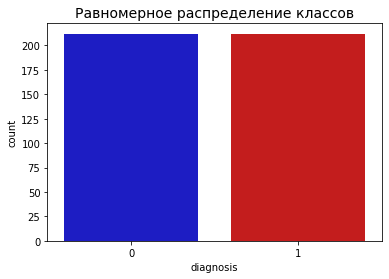

In [27]:
print('Распределение классов в подвыборке данных')
print(new_df['diagnosis'].value_counts()/len(new_df))

sns.countplot('diagnosis', data=new_df, palette=colors)
plt.title('Равномерное распределение классов', fontsize=14)
plt.show()

In [28]:
# Количество данных отнясящихся к классам:
new_df['diagnosis'].value_counts()

1    212
0    212
Name: diagnosis, dtype: int64

##  Обнаружение аномалий
<a id="anomaly"></a>
Для обнаружения аномалий рассмотрим более подробно распределения признаков: построим гистограммы и "ящики с усами" для каждого признака. На этом этапе важно не удалить лишнее.
 **(сейчас удаление выбросов закомечено, т.к. их удаление ничего хорошего не дает)**

In [29]:
# build_hist - функция построения гистограмм по классам

# входные параметры:
# df - набор данных, по которым будут строиться гистограммы
# col_names - массив с названиями столбцов по которым будут строиться гистограммы
# param - параметр для структуры, 22 - значит картинка 2х2 т.е. из 4 гистограмм, 42 - значит 4х2 т.е. из 8 
# param должно соотвествовать длине массива col_names

def build_hist(df, col_names, titles, param):
    # количество строк на картинке
    y = param // 10
    # количество столбцов на картинке
    x = param % 10
    # width - ширина картинки    
    width = 16 
    length = width * y / x 
    
    plt.subplots(figsize=(width, length))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    num = len(col_names)
    p = param * 10
    i = 1
    while i <= num:
        plt.subplot(p+i)
        x1 = new_df[new_df['diagnosis'] == 0][col_names[i-1]]
        x2 = new_df[new_df['diagnosis'] == 1][col_names[i-1]] 
        x1.name, x2.name = 'Д-кач.', 'З-кач.'
        
        x1.hist(alpha=0.3, weights=[1./len(x1)]*len(x1), color='b')
        x2.hist(alpha=0.3, weights=[1./len(x2)]*len(x2), color='r')
        plt.axvline(x1.mean(), color='b', alpha=0.8, linestyle='dashed')
        plt.axvline(x2.mean(), color='r', alpha=0.8, linestyle='dashed')
        plt.title(titles[i-1], fontsize=14)

        #plt.xlabel(col_names[i-1], fontsize=12)
        plt.ylabel(None)
        #plt.ylabel("Частота", fontsize=12)
        #plt.xticks(fontsize=10)  
        #plt.yticks(fontsize=10)
        if i == x:
            plt.legend([x1.name, x2.name])
        i += 1

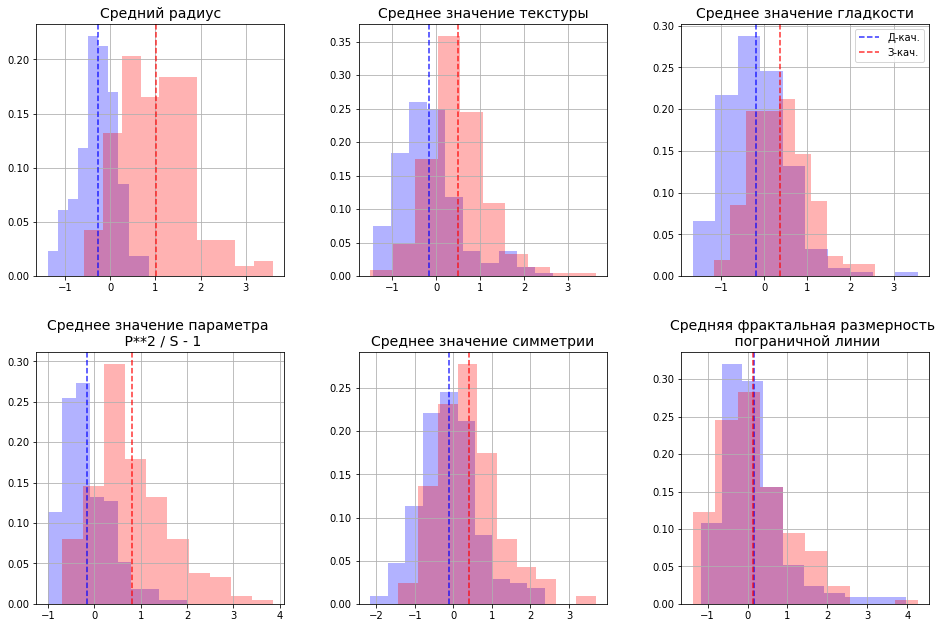

In [30]:
build_hist(new_df, column_names[1:7], rus_titles[1:7], 23)

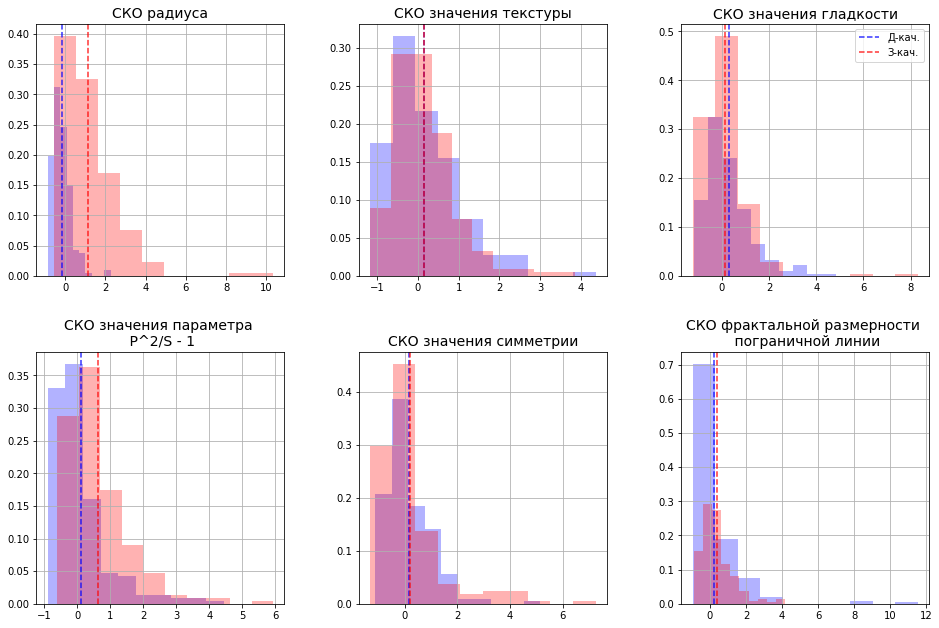

In [31]:
build_hist(new_df, column_names[7:13], rus_titles[7:13], 23)

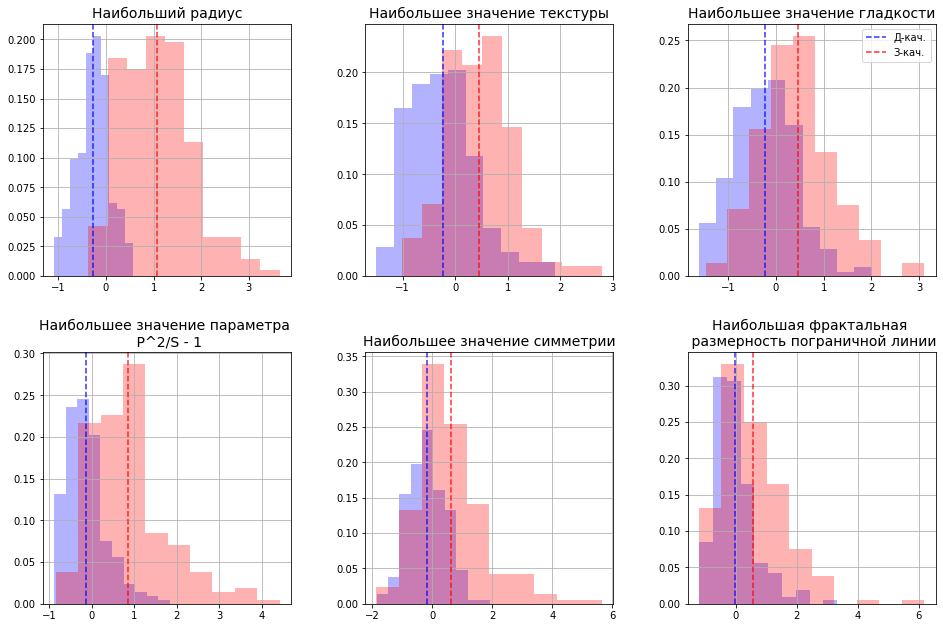

In [32]:
build_hist(new_df, column_names[13:19], rus_titles[13:19], 23)

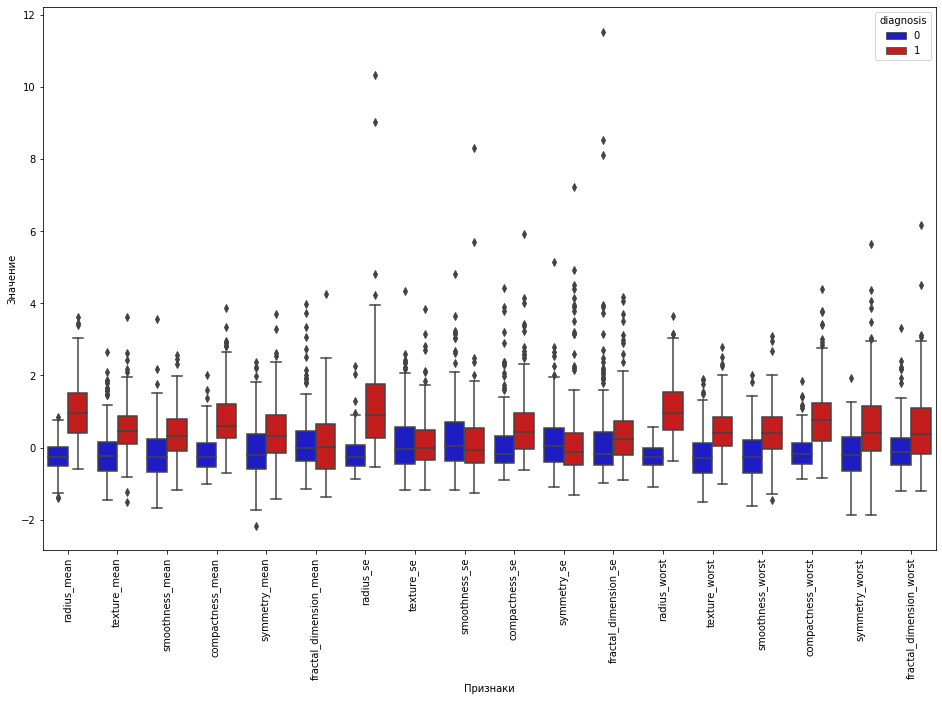

In [33]:
data = pd.melt(new_df,id_vars="diagnosis",
                    var_name="Признаки",
                    value_name='Значение')

plt.figure(figsize=(16,10))
sns.boxplot(x="Признаки", y="Значение", hue="diagnosis", data=data, palette=colors)
plt.xticks(rotation=90)

plt.show()

In [34]:
# по каким столбцам будет удаление выбросов?
# num - массив с номерами столбцов по которым будем избавляться от выбросов

num = [13, 17]

In [35]:
# build_hist - функция построения гистограмм по классам
# входные параметры:
# df - набор данных, по которым будут строиться гистограммы
# col_names - массив с названиями столбцов по которым будут строиться гистограммы
# param - параметр для структуры, 22 - значит картинка 2х2 т.е. из 4 гистограмм, 42 - значит 4х2 т.е. из 8 
# param должно соотвествовать длине массива col_names

# отображенеи build_boxplots в несколько рядов
def build_boxplots_xx(df, col_names, titles, param):
    # количество строк на картинке
    y = param // 10
    # количество столбцов на картинке
    x = param % 10
    # width - ширина картинки    
    width = 16 
    length = width * y / x     
    
    f, axes = plt.subplots(nrows=y, ncols=x, figsize=(width, length))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    i = j = k = 0
    while i < y:
        j = 0
        while j < x:
            sns.boxplot(x="diagnosis", y=col_names[k], data=df, palette=colors, ax=axes[i, j])
            axes[i, j].set_title(titles[k])
            k += 1
            j += 1
        i += 1

# отображенеи build_boxplots в один ряд        
def build_boxplots_x(df, col_names, titles, param):
    # количество столбцов на картинке
    x = len(col_names)
    width = x*4
    length = 4
    
    f, axes = plt.subplots(1, x, figsize=(width, length))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
    i = 0
    while i < x:
        sns.boxplot(x="diagnosis", y=col_names[i], data=df, palette=colors, ax=axes[i])
        axes[i].set_title(titles[i])
        i += 1  
        
# отображенеи build_boxplots
def build_boxplots(df, col_names, titles, param):
    if param >= 10:
        build_boxplots_xx(df, col_names, titles, param)
    else:
        build_boxplots_x(df, col_names, titles, param)

In [36]:
# num - массив с номерами столбцов по которым будем избавляться от выбросов

# cols_b - список признаков по которым будут строиться boxplots
# title_b - список названий к boxplots

cols_b = list()
title_b = list()

i = 0
while i < len(num):
    cols_b.append(column_names[num[i]])
    title_b.append(rus_titles[num[i]])
    i += 1
    
print(cols_b)
print(title_b)

['radius_worst', 'symmetry_worst']
['Наибольший радиус', 'Наибольшее значение симметрии']


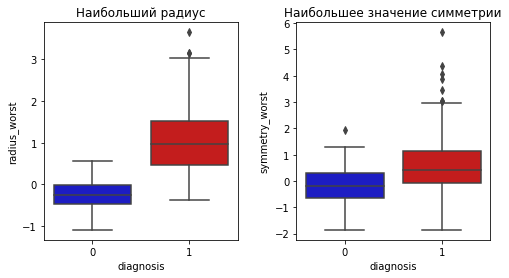

In [37]:
build_boxplots(new_df, cols_b, title_b, 2)

In [38]:
# drop_outliers(column_name, d) - функция для удаления выбросов по одному из признаков, принемает 2 аргумента: 
# df - data frame из которого будут удаляться выбросы,
# column_name - название столбца, d - диагноз (0 - для доброкачественных, 1 - для злокачественных)

def drop_outliers(data_frame, column_name, d):
    print("Удаление выбросов по", column_name, "для диагноза", d)
    column = data_frame[column_name].loc[data_frame['diagnosis'] == d].values
    
    # q25, q75 - значения функции V14, соответствующие перцентилям 25 и 75
    q25, q75 = np.percentile(column, 25), np.percentile(column, 75)
    print('Перцентиль 25: {} | Перцентиль 75: {}'.format(q25, q75))
    
    # column_iqr - интерквартильный интервал (между 1 и 3 квартилями)
    column_iqr = q75 - q25
    print('iqr: {}'.format(column_iqr))
    
    # column_cut_off - значения, находящиеся на таком расстоянии*1.5 от 1 и 3 кваритлей будут считаться выбросами
    column_cut_off = column_iqr * 1.5
    
    # column_lower, column_upper - нижняя и верхняя границы
    column_lower, column_upper = q25 - column_cut_off, q75 + column_cut_off
    print('Отрезать: {}'.format(column_cut_off))
    print('Нижняя грань: {}'.format(column_lower))
    print('Верхняя грань: {}'.format(column_upper))
    
    # outliers - выбросы
    outliers = [x for x in column if x < column_lower or x > column_upper]
    print('Количество выбросов: {}'.format(len(outliers)))
    print('Выбросы: {}'.format(outliers))
    
    # df_dr_out - создаем новый столбец из старого, только без выбросов
    df_dr_out = data_frame.drop(data_frame[(data_frame[column_name] > column_upper) | (data_frame[column_name] < column_lower)].index)
    print('Количество экземпляров после удаления выбросов: ', len(data_frame))
    print('----' * 30)
    
    return df_dr_out

In [39]:
print("Удаление выбросов будет произовдиться по следующим признакам: \n", cols_b)
print("Количество признаков", len(cols_b))

Удаление выбросов будет произовдиться по следующим признакам: 
 ['radius_worst', 'symmetry_worst']
Количество признаков 2


In [40]:
# удаление выбросов будет произодиться по следующим признакам: 
print("Количество экземпляров до удаления выбросов: ", len(new_df), "\n")

#new_df_ = drop_outliers(new_df, cols_b[0], 1)
#new_df = drop_outliers(new_df, cols_b[1], 1)

print("После: ", len(new_df), "\n")

Количество экземпляров до удаления выбросов:  424 

После:  424 



После удаления выбросов:


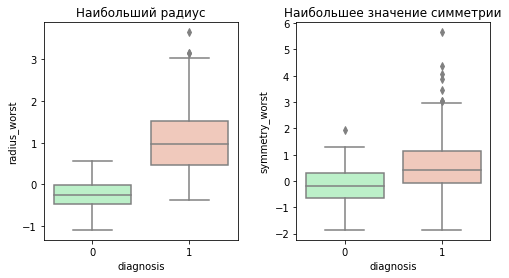

In [41]:
colors = ['#B3F9C5', '#f9c5b3']

print("После удаления выбросов:")
build_boxplots(new_df, cols_b, title_b, 2)

# Классификацая
<a id="classification"></a>

## Уменьшение размерности и кластеризация
<a id="clustering"></a>

Рассмотрим три метода, позволяющие сгруппировать классы:
<ul>
<li> Метод <b>t-SNE</b> - t-distributed Stochastic Neighbor Embedding - стохастическое вложение соседей с t-распределением;</li>
<li> Метод <b>PCA</b> - Principal Component Analysis - метод главных компонент;</li>
<li> Метод <b>TruncatedSVD</b> - Truncated Singular Value Decomposition - усеченное сингулярное разложение.</li>
</ul> 

In [42]:
# уменьшение размерности

X = new_df.drop('diagnosis', axis=1)
y = new_df['diagnosis']


# T-SNE реализация
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE занял {:.2} s".format(t1 - t0))

# PCA реализация
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA занял {:.2} s".format(t1 - t0))

# TruncatedSVD реализация 
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD занял {:.2} s".format(t1 - t0))

T-SNE занял 2.9 s
PCA занял 0.002 s
Truncated SVD занял 0.002 s


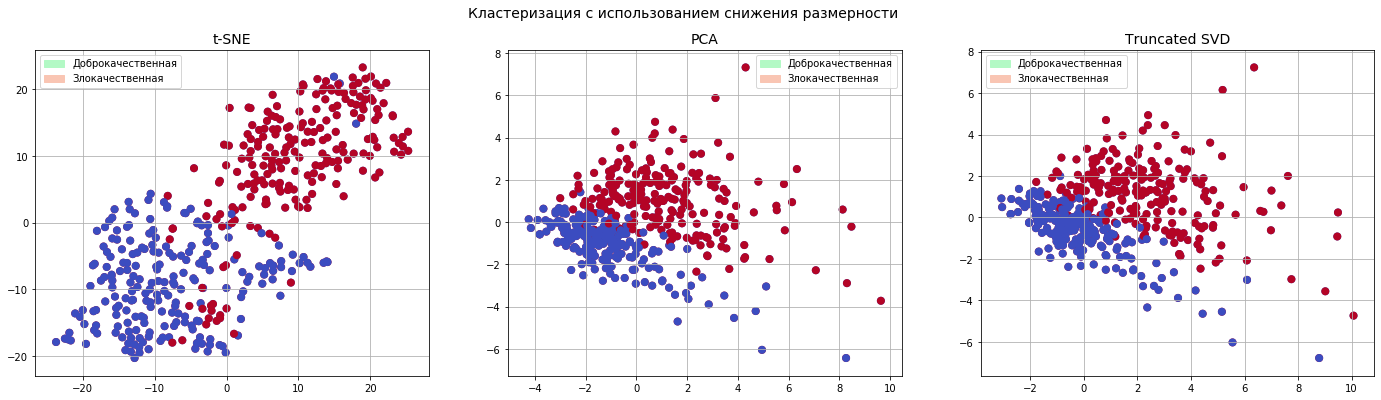

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['Доброкачественная', 'Злокачественная']
f.suptitle('Кластеризация с использованием снижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color=colors[0], label='Доброкачественная')
red_patch = mpatches.Patch(color=colors[1], label='Злокачественная')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Доброкачественная', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Злокачественная', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Доброкачественная', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Злокачественная', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Доброкачественная', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Злокачественная', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2> Классификаторы (UnderSampling):  </h2>
<a id="classifiers"></a>
Для того, что бы понять какой классификатор работает лучше нужно обучить и протестировать каждый. Прежде чем начать разделение данных на наборы для обучения и тестирования нужно отделить функции от меток.

In [44]:
# Создание подвыборки перед проверкой (склонность к переобучению)
X = new_df.drop('diagnosis', axis=1)
y = new_df['diagnosis']

In [45]:
# Данные уже масштабированы, нужно разделить на обучающую и тестовую подвыборки
from sklearn.model_selection import train_test_split

# Это используется для подвыбоки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Преобразовать значения в массив для алгоритмов классификации
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [47]:
# Реализуем простые классификаторы

classifiers = {
    "Логистическая регрессия": LogisticRegression(),
    "К-средних": KNeighborsClassifier(),
    "Опорные вектора": SVC(),
    "Дерево решений": DecisionTreeClassifier()
}

In [48]:
# наши оценки получают высокую точность даже на проверочном наборе
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Классификатор", classifier.__class__.__name__, "имеет оценку на тестовом наборе ", round(training_score.mean(), 2) * 100, "%")

Классификатор LogisticRegression имеет оценку на тестовом наборе  95.0 %
Классификатор KNeighborsClassifier имеет оценку на тестовом наборе  95.0 %
Классификатор SVC имеет оценку на тестовом наборе  95.0 %
Классификатор DecisionTreeClassifier имеет оценку на тестовом наборе  91.0 %


In [49]:
# Будет использоваться GridSearchCV для поиска параметров, дающих наилучшую прогностическую оценку для классификаторов.
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# Логистическая регрессия лучший вариант
log_reg = grid_log_reg.best_estimator_

# K-средних
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# K-средних лучший вариант
knears_neighbors = grid_knears.best_estimator_

# SVC
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC лучший вариант
svc = grid_svc.best_estimator_

# Дерево решений
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# Дерево решений лучший вариант
tree_clf = grid_tree.best_estimator_

In [50]:
# Случай переобучения

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Классификатор Логистической регресси имеет оценку на проверочном наборе данных: ', 
      round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Классификатор метода К-средних соседей имеет оценку на проверочном наборе данных', 
      round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Классификатор метода Опорных векторов имеет оценку на проверочном наборе данных', 
      round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('Классификатор Дерева решений имеет оценку на проверочном наборе данных', 
      round(tree_score.mean() * 100, 2).astype(str) + '%')

Классификатор Логистической регресси имеет оценку на проверочном наборе данных:  95.56%
Классификатор метода К-средних соседей имеет оценку на проверочном наборе данных 94.99%
Классификатор метода Опорных векторов имеет оценку на проверочном наборе данных 95.28%
Классификатор Дерева решений имеет оценку на проверочном наборе данных 93.49%


In [51]:
# Мы будем создавать подвыборку во время проверки
undersample_X = df.drop('diagnosis', axis=1)
undersample_y = df['diagnosis']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Использование техники NearMiss
# Распределение NearMiss (просто чтобы посмотреть, как он распределяет метки, мы не будем использовать эти переменные)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Кросс-валидация правильный путь

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) 
    # NearMiss происходит во время перекрестной проверки, не раньше..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [104 105 111 113 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359

### Кривые обучения
<ul>
<li> Чем <b> больше разница </b> между оценкой при обучении и оценкой при кросс-валидации, тем выше вероятность того, что модель <b> переобучаена (высокое расхождение) </b>. </li>
<li> Если оценка низкая как на обучающем, так и на проверочном наборах, то модель <b> недостаточно подходит (высокий уклон) </b> </li>
</ul>

In [52]:
# Кривые обучения 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
       
    
    # Логистическая регрессия
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Обучающий набор")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Проверочный набор")
    ax1.set_title("Метод: Логистическая регрессия", fontsize=16)
    ax1.set_xlabel('Длительность обчения (m)')
    ax1.set_ylabel('Точность')
    ax1.grid(True)
    ax1.legend(loc="best")

    
    # К-средних
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Обучающий набор")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Проверочный набор")
    ax2.set_title("Метод: К-средних соседей", fontsize=16)
    ax2.set_xlabel('Длительность обчения (m)')
    ax2.set_ylabel('Точность')
    ax2.grid(True)
    ax2.legend(loc="best")
        
        
    # Опорные вектора
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Обучающий набор")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Проверочный набор")
    ax3.set_title("Метод: Опорные вектора", fontsize=16)
    ax3.set_xlabel('Длительность обчения (m)')
    ax3.set_ylabel('Точность')
    ax3.grid(True)
    ax3.legend(loc="best")
          
    
    # Дерово решений
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Обучающий набор")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Проверочный набор")
    ax4.set_title("Метод: Дерево решений", fontsize=16)
    ax4.set_xlabel('Длительность обчения (m)')
    ax4.set_ylabel('Точность')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

Кривые обучения классификаторов разных методов:


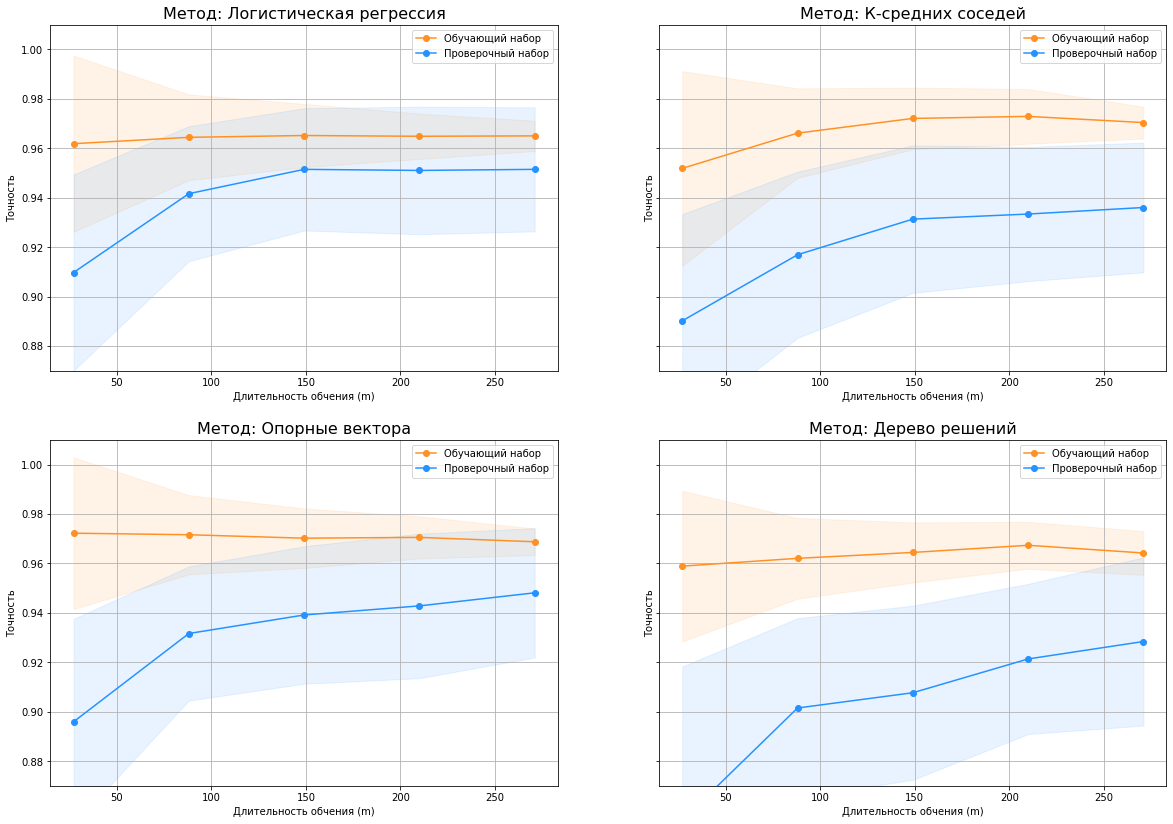

In [53]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
print("Кривые обучения классификаторов разных методов:")
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)
plt.show()

In [54]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Создать подвыборку со всеми оценками и именами классификаторов

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [55]:
from sklearn.metrics import roc_auc_score

print('Логистическая регрессия: ', roc_auc_score(y_train, log_reg_pred))
print('К-средних: ', roc_auc_score(y_train, knears_pred))
print('Опорные вектора: ', roc_auc_score(y_train, svc_pred))
print('Дерево решений: ', roc_auc_score(y_train, tree_pred))

Логистическая регрессия:  0.9901489835700361
К-средних:  0.9500313283208021
Опорные вектора:  0.9912280701754386
Дерево решений:  0.9324352548036758


### ROC-кривые
#### Термины:
<ul>
<li><b>Правильные позитивные оценки (True Positives Rate):</b> правильно классифицированные злокачественные опухоли</li>
<li><b>Неправильные позитивные оценки (False Positives Rate):</b> неправильно классифицированные злокачественные опухоли</li>
<li><b>Правильные негитивные оценки (True Negative Rate):</b> правильно классифицированные доброкачественные опухоли</li>
<li><b>Неправильные негативные оценки (False Negative Rate):</b> неправильно классифицированные доброкачественные опухоли</li>
<li><b>Точность (Precision): </b>  Правильные позитивные/(Правильные позитивные + Неправильные позитивные)  </li>
<li><b>Полнота (Recall): </b> Правильные позитивные/(Правильные позитивные + Неправильные негитвные)   </li>
<li> Точность, как следует из названия, говорит о том, насколько точна модель в обнаружении злокачественных опухолей, а полнота - это количество случаев злокачественных опухолей, которые модель способна обнаружить.</li>
<li><b> Компромисс Точность/Полнота: </b> Чем точнее (избирательнее) наша модель, тем меньше случаев злокачественных опухолей она будет выявлять. Пример: Если модель имеет точность 95%, это значит, злокачественными будут объвлены только те случаи в которых модель имеет точность определения (уверенность) - 95% или более. Допустим, что есть еще 5 случаев, в которых наша модель уверена на 90%, что это злокачественные опухоли. То есть если мы снизим точность, будет больше случаев, которые наша модель сможет обнаружить, но до брокачественных опухолей, которые будут определены как злокачественные станет больше</li>
</ul>

In [56]:
#ROC кривая - по оси Y доля правильно классифицированных положительных ответов (т. явл. мошеннической)
#по оси X доля неправильно классифицированных отрицательных ответов (т. не явл. мошеннической) 
#(вспоминаем ошибки 1-го и 2-го рода)

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(12,8))
    plt.title('ROC Кривые \n Лучшие 4 классификатора', fontsize=18)
    plt.plot(log_fpr, log_tpr, label=     'Классификатор - Логистическая регрессия, Оценка: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label= 'Классификатор - К-средних соседей (k-near), Оценка: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label=     'Классификатор - Опорные вектора (svc), Оценка: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label=   'Классификатор - Дерево решений, Оценка: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.ylabel('Правильные позитивные оценки', fontsize=16)
    plt.xlabel('Неправильные позитивные оценки', fontsize=16)    
    plt.annotate('Минимальное значение ROC - 50% \n (случайное определение классов)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

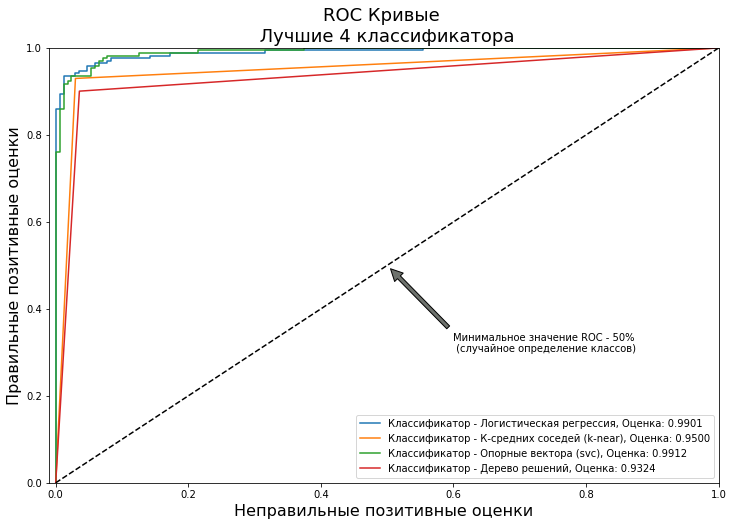

In [57]:
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## Более подробное рассмотрение логистической регрессии
<a id="logistic"></a>
В этом разделе мы более глубоко рассмотрим <b> классификатор Логистической регрессии </b>.

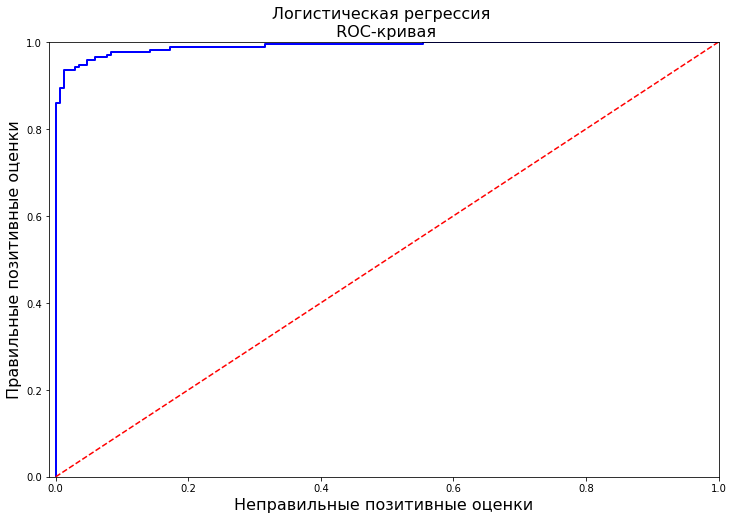

In [58]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Логистическая регрессия \n ROC-кривая', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Неправильные позитивные оценки', fontsize=16)
    plt.ylabel('Правильные позитивные оценки', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [59]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [60]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Случай переобучения
print('---' * 40)
print('Переобучение: \n')
print('Точность: {:.2f}'.format(precision_score(y_train, y_pred)))
print('Полнота: {:.2f}'.format(recall_score(y_train, y_pred)))
print('F1-мера: {:.2f}'.format(f1_score(y_train, y_pred)))
print('аccuracy: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 40)

# Как должно быть
print('Как должно быть: \n')
print("Точность: {:.2f}".format(np.mean(undersample_precision)))
print("Полнота: {:.2f}".format(np.mean(undersample_recall)))
print("F1-мера: {:.2f}".format(np.mean(undersample_f1)))
print("accuracy: {:.2f}".format(np.mean(undersample_accuracy)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Переобучение: 

Точность: 0.98
Полнота: 0.96
F1-мера: 0.97
аccuracy: 0.97
------------------------------------------------------------------------------------------------------------------------
Как должно быть: 

Точность: 0.34
Полнота: 0.29
F1-мера: 0.31
accuracy: 0.97
------------------------------------------------------------------------------------------------------------------------


In [61]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [62]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Среднее значение точность/полнота: {0:0.2f}'.format(
      undersample_average_precision))

Среднее значение точность/полнота: 0.99


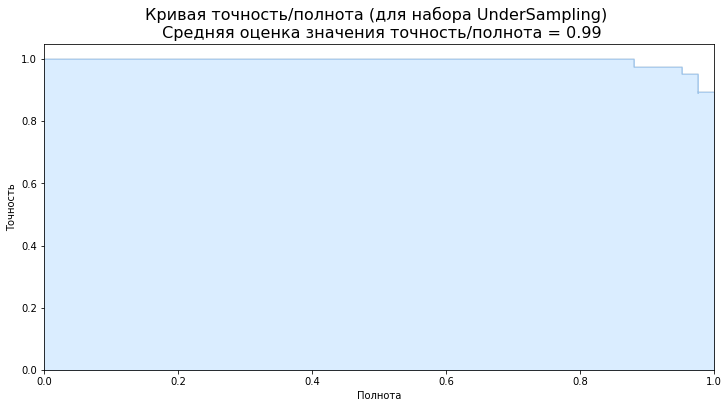

In [63]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая точность/полнота (для набора UnderSampling) \n Средняя оценка значения точность/полнота = {0:0.2f}'.format(
          undersample_average_precision), fontsize=16)
plt.show()

## SMOTE техника (Over-Sampling):
<a id="smote"></a>

In [64]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Размер выборки X (train): {} | Размер выборки y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Размер выборки X (test): {} | Размер выборки y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# Список для добавленя значений, и дальнейшего нахождения среднего
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Классификатор с оптимальными параметрами
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Применение метода SMOTE 
# Правильный путь использования кросс-валидации
# Параметры
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) 
    # SMOTE происходит во время кросс-валидации, а не раньше...
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 40)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("Точность: {}".format(np.mean(precision_lst)))
print("Полнота: {}".format(np.mean(recall_lst)))
print("F1-мера: {}".format(np.mean(f1_lst)))
print('---' * 40)

Размер выборки X (train): 456 | Размер выборки y (train): 456
Размер выборки X (test): 113 | Размер выборки y (test): 113
------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9626851409460105
Точность: 0.9596154825566592
Полнота: 0.9411764705882353
F1-мера: 0.9489921358982703
------------------------------------------------------------------------------------------------------------------------


In [65]:
labels = ['Доброкачественные', 'Злокачественные']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

                   precision    recall  f1-score   support

Доброкачественные       0.99      0.97      0.98        71
  Злокачественные       0.95      0.98      0.96        42

         accuracy                           0.97       113
        macro avg       0.97      0.97      0.97       113
     weighted avg       0.97      0.97      0.97       113



In [66]:
y_score = best_est.decision_function(original_Xtest)

In [67]:
average_precision = average_precision_score(original_ytest, y_score)

print('Среднее значение точность/полнота: {0:0.2f}'.format(
      average_precision))

Среднее значение точность/полнота: 1.00


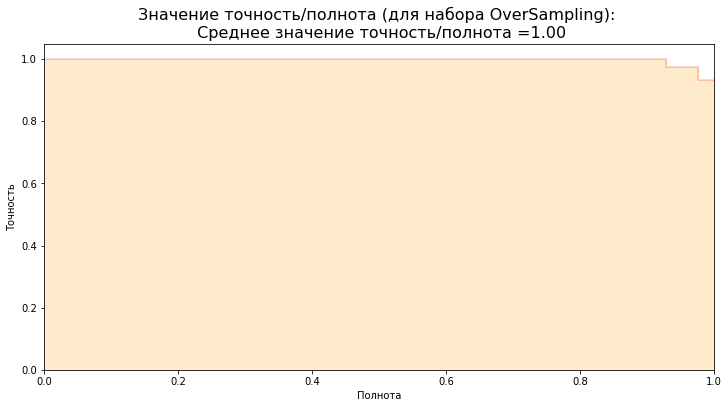

In [68]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Значение точность/полнота (для набора OverSampling): \n Среднее значение точность/полнота ={0:0.2f}'.format(
          average_precision), fontsize=16)
plt.show()

In [69]:
# Алгоритм SMOTE (OverSampling) после разделения и кросс-валидации
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [70]:
#  Мы улучшаем значение примерно на 2% We Improve the score by 2% points approximately 
# Использование GridSearchCV и других моделей.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Обучение на наборе данных OverSampleing заняла: {} sec".format(t1 - t0))

Обучение на наборе данных OverSampleing заняла: 0.0029909610748291016 sec


## Тестирование классификаторов
<a id="testing"></a>

<ul>
<li> <b>Random UnderSampling:</b>     
Оценим окончательную производительность классификационных моделей на подмножестве данных UnderSampling. <b> (Не на данных исходного набора) </b> </li>
<li> <b> Классификационные модели: </b> Лучшими моделями были <b> Логистическая регрессия </b> и <b> классификатор метода опорных векторов (SVС).</b>  </li>
</ul>

### Матрица ошибок:
Что показывает матрица ошибок:
<ul>
<li><b>Верхний левый квадрат: </b> Количество <b>правильно</b> классифицированных <b>доброкачественных</b> опухолей. </li>
<li><b>Верхний правый квадрат:</b> Количество <b>не правильно</b> классифицированных доброкачественных опухолей, т.е. количество опухолей классифицированных злокачественными, но на самом деле <b> не являющиеся злокачественными</b>. </li>
<li><b>Нижний левый квадрат:</b> Количество <b>не правильно</b> классифицированных злокачественных опухолей, т.е. количество опухолей классифицированных доброкачественными, но на самом деле <b> являющиеся злокачественными </b>. </li>
<li><b>Нижний правый квадрат:</b> Количество <b>правильно</b> классифицированных <b>злокачественных</b> опухолей. </li>
</ul>

Матрацы ошибок для различных классификаторов:


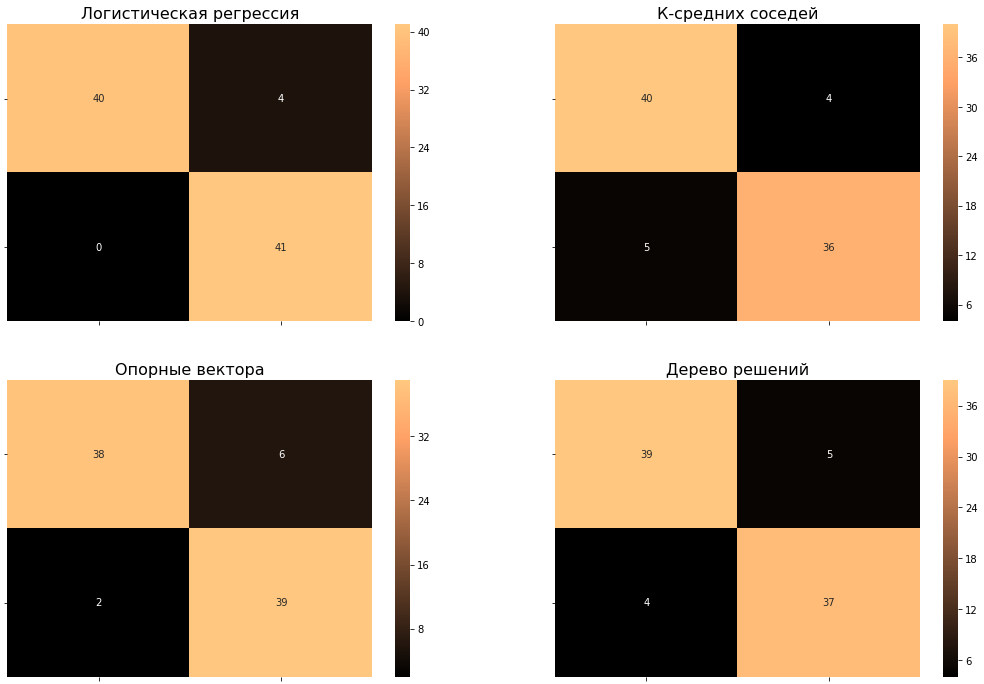

In [71]:
from sklearn.metrics import confusion_matrix

# Логистическая регрессия на наборе данных, полученным с использованием метода SMOTE
y_pred_log_reg = log_reg_sm.predict(X_test)

# Другие модели на наборе данных, полученным с использованием метода UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(18,12))

print("Матрацы ошибок для различных классификаторов:")
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Логистическая регрессия", fontsize=16)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("К-средних соседей", fontsize=16)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Опорные вектора", fontsize=16)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Дерево решений", fontsize=16)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [72]:
from sklearn.metrics import classification_report

print('Логистическая регрессия:')
print(classification_report(y_test, y_pred_log_reg))

print('К-средних соседей:')
print(classification_report(y_test, y_pred_knear))

print('Опорные вектора:')
print(classification_report(y_test, y_pred_svc))

print('Дерево решений:')
print(classification_report(y_test, y_pred_tree))

Логистическая регрессия:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.91      1.00      0.95        41

    accuracy                           0.95        85
   macro avg       0.96      0.95      0.95        85
weighted avg       0.96      0.95      0.95        85

К-средних соседей:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        44
           1       0.90      0.88      0.89        41

    accuracy                           0.89        85
   macro avg       0.89      0.89      0.89        85
weighted avg       0.89      0.89      0.89        85

Опорные вектора:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        44
           1       0.87      0.95      0.91        41

    accuracy                           0.91        85
   macro avg       0.91      0.91      0.91        85
weighted avg 

In [73]:
# Окончательные значения на тестовом наборе для классификатора логистической регрессии
from sklearn.metrics import accuracy_score

# Логистическая регрессия с набором данных Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)


# Логистическая регрессия с использованием метода SMOTE (Лучшее значение accuracy с SMOTE)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

print("Значение accuracy для классификатора Логистической регрессии \n на наборах данных, полученных разными техниками: ")

final_df

Значение accuracy для классификатора Логистической регрессии 
 на наборах данных, полученных разными техниками: 


,Technique,Score
0,Random UnderSampling,0.952941
1,Oversampling (SMOTE),0.973451


## Нейронные сети, обучаемые на разных наборах данных Under-Sample и Over-Sample (SMOTE)
<a id="neural_networks"></a>
Будет реализована простая нейронная сеть (с одним скрытым слоем), чтобы увидеть, на каком наборе данных (under-sample и over-sample), реализована лучшая модель. <br><br>

<ul>
<li><b>Набор данных: </b> В финальной фазе тестирования модель будет обучена на обоих наборах данных: <b>Random Under-Sample</b> и <b>Over-Sample</b>. Для получения оценки предсказательной способности будет использоваться <b> исходный набор тестовых данных. </b></li>
<li><b>Структура нейронной сети: </b> Это будет простая модель, состоящая из одного входного слоя (где количество узлов равно количеству признаков объектов), один скрытый слой с 18 узлами и один выходной слой, состоящий из двух возможных результатов 0 или 1. </li>

### Keras || UnderSampling

In [74]:
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(18, activation='relu'),
    Dense(2, activation='softmax')
])

In [75]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                342       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________


In [76]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=50, shuffle=True, verbose=2)

Train on 271 samples, validate on 68 samples
Epoch 1/50
271/271 - 1s - loss: 0.6852 - accuracy: 0.5867 - val_loss: 0.6029 - val_accuracy: 0.7206
Epoch 2/50
271/271 - 0s - loss: 0.6221 - accuracy: 0.7454 - val_loss: 0.5651 - val_accuracy: 0.8088
Epoch 3/50
271/271 - 0s - loss: 0.5623 - accuracy: 0.8044 - val_loss: 0.5227 - val_accuracy: 0.8235
Epoch 4/50
271/271 - 0s - loss: 0.5020 - accuracy: 0.8339 - val_loss: 0.4803 - val_accuracy: 0.8824
Epoch 5/50
271/271 - 0s - loss: 0.4438 - accuracy: 0.8782 - val_loss: 0.4383 - val_accuracy: 0.8824
Epoch 6/50
271/271 - 0s - loss: 0.3870 - accuracy: 0.9077 - val_loss: 0.3957 - val_accuracy: 0.8824
Epoch 7/50
271/271 - 0s - loss: 0.3358 - accuracy: 0.9262 - val_loss: 0.3553 - val_accuracy: 0.8676
Epoch 8/50
271/271 - 0s - loss: 0.2922 - accuracy: 0.9262 - val_loss: 0.3159 - val_accuracy: 0.8971
Epoch 9/50
271/271 - 0s - loss: 0.2565 - accuracy: 0.9336 - val_loss: 0.2829 - val_accuracy: 0.8971
Epoch 10/50
271/271 - 0s - loss: 0.2278 - accuracy: 0.9

In [78]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [79]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [80]:
import itertools

# Создание матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """
    Эта функция делает график матрицы ошибок.
    Нормализация может быть применена установкой `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная матрица ошибок")
    else:
        print('Матрица ошибок без нормализации')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
#    plt.ylabel('Позитивные ответы')
#    plt.xlabel('Негативные ответы')

Матрица ошибок без нормализации
[[68  3]
 [ 0 42]]
Матрица ошибок без нормализации
[[71  0]
 [ 0 42]]


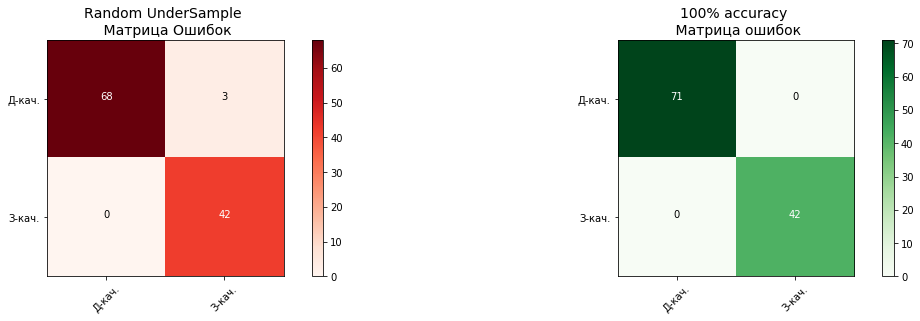

In [81]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['Д-кач.', 'З-кач.']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Матрица Ошибок", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="100% accuracy \n Матрица ошибок", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):

In [82]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(18, activation='relu'),
    Dense(2, activation='softmax')
])

In [83]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=50, shuffle=True, verbose=2)

Train on 457 samples, validate on 115 samples
Epoch 1/50
457/457 - 0s - loss: 0.7728 - accuracy: 0.4508 - val_loss: 0.9864 - val_accuracy: 0.0609
Epoch 2/50
457/457 - 0s - loss: 0.7471 - accuracy: 0.4705 - val_loss: 0.9647 - val_accuracy: 0.0696
Epoch 3/50
457/457 - 0s - loss: 0.7238 - accuracy: 0.4923 - val_loss: 0.9446 - val_accuracy: 0.0783
Epoch 4/50
457/457 - 0s - loss: 0.7001 - accuracy: 0.5230 - val_loss: 0.9255 - val_accuracy: 0.0870
Epoch 5/50
457/457 - 0s - loss: 0.6788 - accuracy: 0.5492 - val_loss: 0.9078 - val_accuracy: 0.0870
Epoch 6/50
457/457 - 0s - loss: 0.6585 - accuracy: 0.5711 - val_loss: 0.8915 - val_accuracy: 0.0870
Epoch 7/50
457/457 - 0s - loss: 0.6389 - accuracy: 0.5842 - val_loss: 0.8755 - val_accuracy: 0.1043
Epoch 8/50
457/457 - 0s - loss: 0.6203 - accuracy: 0.5996 - val_loss: 0.8605 - val_accuracy: 0.1217
Epoch 9/50
457/457 - 0s - loss: 0.6030 - accuracy: 0.6149 - val_loss: 0.8474 - val_accuracy: 0.1217
Epoch 10/50
457/457 - 0s - loss: 0.5864 - accuracy: 0.

In [85]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [86]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Матрица ошибок без нормализации
[[68  3]
 [ 2 40]]
Матрица ошибок без нормализации
[[71  0]
 [ 0 42]]


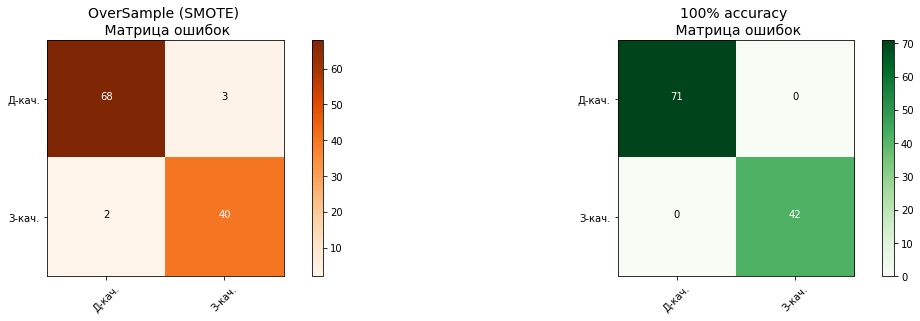

In [87]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['Д-кач.', 'З-кач.']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Матрица ошибок", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="100% accuracy \n Матрица ошибок", cmap=plt.cm.Greens)